In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wfdb import rdrecord, processing
import pywt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
sns.set_style('whitegrid')
np.set_printoptions(precision=3, suppress=True)

# List db records

In [4]:
import glob

In [5]:
nsr_files = glob.glob("./data/nsrdb/*.hea")
nsr_records = [f[:-4] for f in nsr_files]

In [6]:
len(nsr_records)

18

In [7]:
nsr_records

['./data/nsrdb\\16265',
 './data/nsrdb\\16272',
 './data/nsrdb\\16273',
 './data/nsrdb\\16420',
 './data/nsrdb\\16483',
 './data/nsrdb\\16539',
 './data/nsrdb\\16773',
 './data/nsrdb\\16786',
 './data/nsrdb\\16795',
 './data/nsrdb\\17052',
 './data/nsrdb\\17453',
 './data/nsrdb\\18177',
 './data/nsrdb\\18184',
 './data/nsrdb\\19088',
 './data/nsrdb\\19090',
 './data/nsrdb\\19093',
 './data/nsrdb\\19140',
 './data/nsrdb\\19830']

In [8]:
nsr_records = [f.replace("\\", "/")[:-4] for f in nsr_files]

In [9]:
nsr_records

['./data/nsrdb/16265',
 './data/nsrdb/16272',
 './data/nsrdb/16273',
 './data/nsrdb/16420',
 './data/nsrdb/16483',
 './data/nsrdb/16539',
 './data/nsrdb/16773',
 './data/nsrdb/16786',
 './data/nsrdb/16795',
 './data/nsrdb/17052',
 './data/nsrdb/17453',
 './data/nsrdb/18177',
 './data/nsrdb/18184',
 './data/nsrdb/19088',
 './data/nsrdb/19090',
 './data/nsrdb/19093',
 './data/nsrdb/19140',
 './data/nsrdb/19830']

In [10]:
# scd database
sdd_files = glob.glob("./data/scddb/*.hea")
sdd_records = [f[:-4] for f in sdd_files]  # remove the ".hea" extension

In [11]:
len(sdd_records)

23

In [12]:
sdd_records

['./data/scddb\\30',
 './data/scddb\\31',
 './data/scddb\\32',
 './data/scddb\\33',
 './data/scddb\\34',
 './data/scddb\\35',
 './data/scddb\\36',
 './data/scddb\\37',
 './data/scddb\\38',
 './data/scddb\\39',
 './data/scddb\\40',
 './data/scddb\\41',
 './data/scddb\\42',
 './data/scddb\\43',
 './data/scddb\\44',
 './data/scddb\\45',
 './data/scddb\\46',
 './data/scddb\\47',
 './data/scddb\\48',
 './data/scddb\\49',
 './data/scddb\\50',
 './data/scddb\\51',
 './data/scddb\\52']

In [13]:
sdd_records = [f.replace("\\", "/")[:-4] for f in sdd_files]

In [14]:
sdd_records

['./data/scddb/30',
 './data/scddb/31',
 './data/scddb/32',
 './data/scddb/33',
 './data/scddb/34',
 './data/scddb/35',
 './data/scddb/36',
 './data/scddb/37',
 './data/scddb/38',
 './data/scddb/39',
 './data/scddb/40',
 './data/scddb/41',
 './data/scddb/42',
 './data/scddb/43',
 './data/scddb/44',
 './data/scddb/45',
 './data/scddb/46',
 './data/scddb/47',
 './data/scddb/48',
 './data/scddb/49',
 './data/scddb/50',
 './data/scddb/51',
 './data/scddb/52']

# Load a Single ECG Record

In [23]:
scddb_test_record=rdrecord('./data/scddb/48', channels=[0])

In [24]:
scddb_test_record.fs

250

In [25]:
nsrdb_test_record=rdrecord('./data/nsrdb/19088', channels=[0])

In [26]:
nsrdb_test_record.fs

128

In [27]:
from scipy.signal import resample_poly, butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Downsample 250 -> 128

In [37]:
def lowpass_filter(signal, cutoff, fs, order=4):
    """
    Applies a low-pass Butterworth filter with given cutoff and order.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

In [38]:
# For optional style
import seaborn as sns
sns.set_style('whitegrid')
np.set_printoptions(precision=3, suppress=True)

def plot_signals(signals, titles, fs=128, sample_range=None):
    """
    Plots multiple signals in subplots.
    
    Parameters:
      signals (list of np.ndarray): signals to plot
      titles (list of str): list of titles for each subplot
      fs (int): sampling frequency for x-axis
      sample_range (tuple): (start, end) samples to plot, optional
    """
    n_signals = len(signals)
    fig, axes = plt.subplots(n_signals, 1, figsize=(12, 3*n_signals), sharex=False)
    
    if n_signals == 1:
        axes = [axes]  # make it iterable

    for i, ax in enumerate(axes):
        sig = signals[i]
        
        if sample_range is not None:
            start, end = sample_range
            sig = sig[start:end]
            x_time = np.arange(start, end) / fs
        else:
            x_time = np.arange(len(sig)) / fs
        
        ax.plot(x_time, sig, label=titles[i])
        ax.set_title(titles[i])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        ax.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()


In [39]:
def downsample_ecg(ecg_signal, old_fs=250, new_fs=128, cutoff=64):
    """
    Downsamples an ECG signal from old_fs to new_fs.
    1) Low-pass filter at `cutoff` Hz to prevent aliasing.
    2) Resample using resample_poly.
    """
    # 1) Low-pass
    ecg_filtered = lowpass_filter(ecg_signal, cutoff=cutoff, fs=old_fs, order=4)
    # 2) Downsample
    ecg_down = resample_poly(ecg_filtered, up=new_fs, down=old_fs)
    return ecg_down

# denoise normalization

In [40]:
def wavelet_denoise(ecg_segment, wavelet='sym5', level=5):
    """
    Wavelet-based denoising using discrete wavelet transform.
    """
    coeffs = pywt.wavedec(ecg_segment, wavelet, level=level)
    for i in range(1, len(coeffs)):  # skip approx coeff (i=0)
        threshold = 0.04 * np.max(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    denoised = pywt.waverec(coeffs, wavelet)
    return denoised[:len(ecg_segment)]

def normalize_ecg_segment(ecg_segment):
    """
    Normalized Absolute Deviation (NADev).
    """
    median_val = np.median(ecg_segment)
    mad = np.median(np.abs(ecg_segment - median_val))
    if mad == 0:
        mad = 1e-8
    ecg_norm = (ecg_segment - median_val) / mad
    return ecg_norm


# R peak detect

In [41]:
def detect_r_peaks(ecg_segment, fs):
    qrs_inds = processing.xqrs_detect(ecg_segment, fs=fs, verbose=False)
    return qrs_inds

def compute_rr_intervals(r_peaks, fs):
    if len(r_peaks) < 2:
        return np.array([])
    rr_int = np.diff(r_peaks) / fs
    return rr_int

# demo

In [43]:
# Example record path (without .hea extension)
# Suppose you have a file: ./SCD_data/record1.hea, record1.dat
record_path = "./data/scddb/48"

# 3.1 Load the raw ECG
record = rdrecord(record_path, channels=[0])  # e.g. lead II
ecg_raw = record.p_signal.flatten()
fs_original = record.fs
print(f"Original ECG length: {len(ecg_raw)} samples, fs={fs_original} Hz")

Original ECG length: 22143750 samples, fs=250 Hz


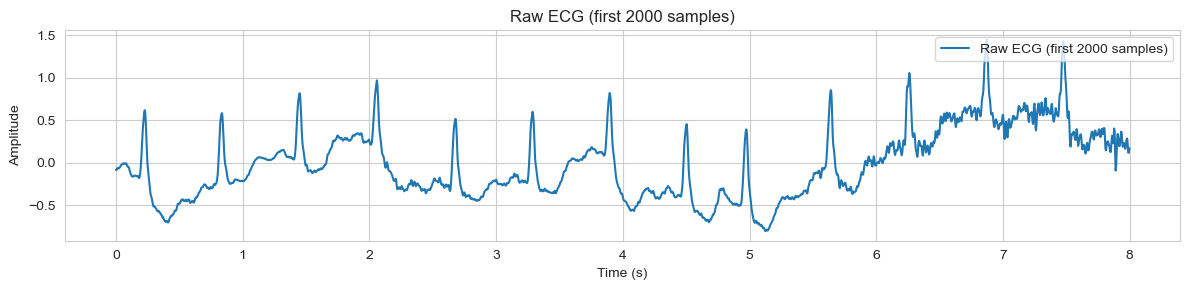

In [44]:
# Plot the first ~2000 samples to see raw
plot_signals(
    [ecg_raw],
    ["Raw ECG (first 2000 samples)"],
    fs=fs_original,
    sample_range=(0, 2000)  # you can adjust as desired
)


In [46]:
ecg_raw

array([-0.081, -0.084, -0.076, ..., -0.158, -0.155, -0.158])

In [47]:
ecg_filtered = lowpass_filter(ecg_raw, cutoff=64, fs=250, order=4)

In [48]:
ecg_filtered

array([nan, nan, nan, ..., nan, nan, nan])

In [49]:
ecg_down = resample_poly(ecg_raw, up=128, down=250)
fs_new = 128

In [50]:
ecg_down

array([-0.063, -0.082, -0.06 , ..., -0.16 , -0.152, -0.167])

In [63]:
len(ecg_down)

11337600

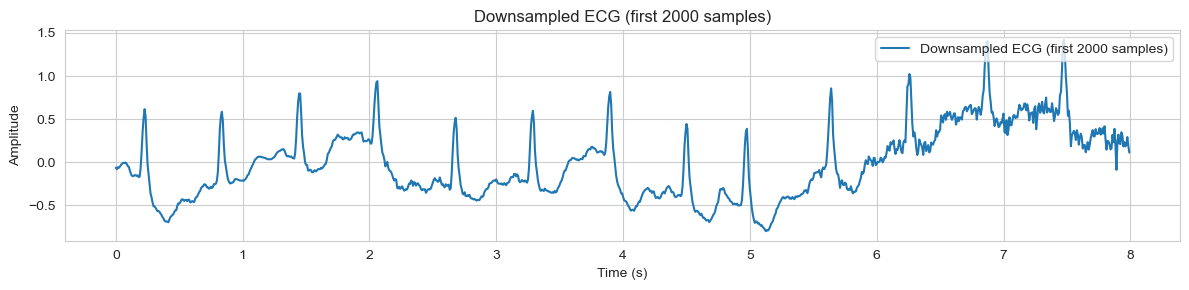

In [51]:
plot_signals(
        [ecg_down],
        ["Downsampled ECG (first 2000 samples)"],
        fs=fs_new,
        sample_range=(0, int(2000*(128/250)))  # scale the sample range approximately
    )

In [52]:
def segment_ecg_signal(ecg, fs, segment_length_sec=300):
    """
    Returns a list of segments each 5-min (300 s).
    """
    samples_per_segment = segment_length_sec * fs
    segments = []
    start = 0
    while start + samples_per_segment <= len(ecg):
        end = start + samples_per_segment
        seg = ecg[start:end]
        segments.append(seg)
        start = end
    return segments

ecg_segments = segment_ecg_signal(ecg_down, fs_new, 300)
print(f"Number of 5-min segments: {len(ecg_segments)}")

Number of 5-min segments: 295


In [55]:
len(ecg_segments[0])

38400

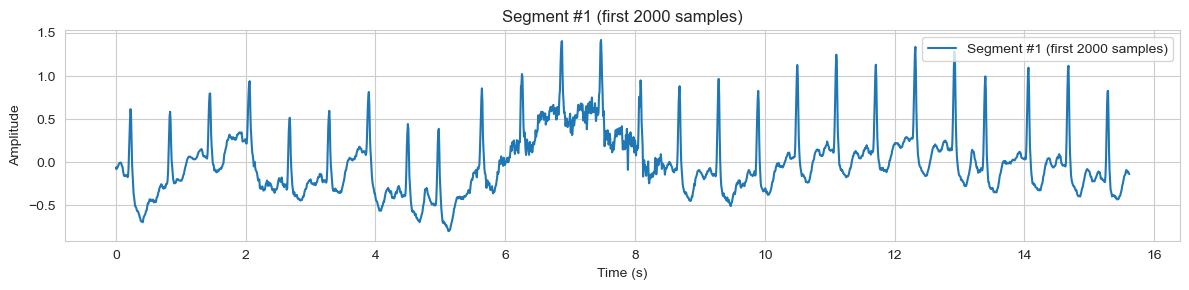

In [62]:
plot_signals(
    [ecg_segments[0]],
    ["Segment #1 (first 2000 samples)"],
    fs=fs_new,
    sample_range=(0, 2000)
)

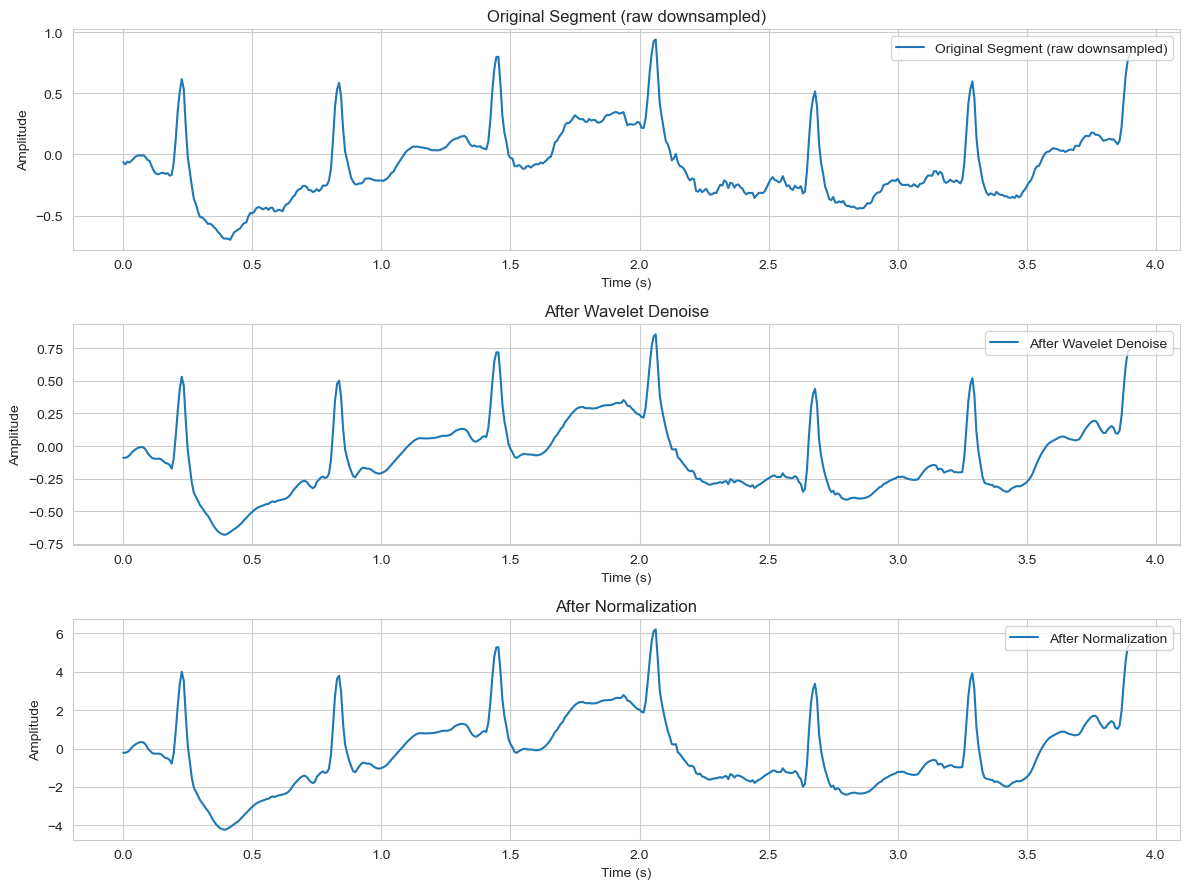

In [66]:
segment_0 = ecg_segments[0]

# a) Wavelet Denoise
seg_denoised = wavelet_denoise(segment_0)

# b) Normalize
seg_norm = normalize_ecg_segment(seg_denoised)

plot_signals(
    [segment_0, seg_denoised, seg_norm],
    [
        "Original Segment (raw downsampled)", 
        "After Wavelet Denoise", 
        "After Normalization"
    ],
    fs=fs_new,
    sample_range=(0, 500)
)


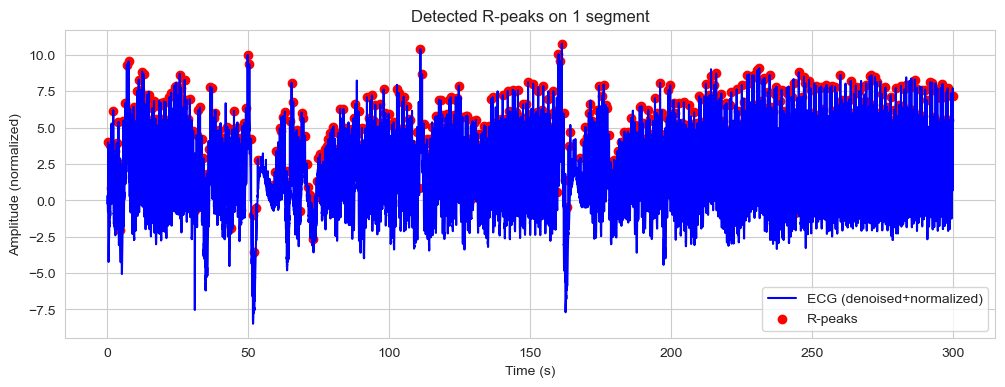

In [72]:
r_peaks = detect_r_peaks(seg_norm, fs=fs_new)

plt.figure(figsize=(12,4))
time_axis = np.arange(len(seg_norm)) / fs_new
plt.plot(time_axis, seg_norm, label="ECG (denoised+normalized)", color='blue')
plt.scatter(time_axis[r_peaks], seg_norm[r_peaks], color='red', label="R-peaks")
plt.title("Detected R-peaks on 1 segment")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (normalized)")
plt.legend()
plt.show()


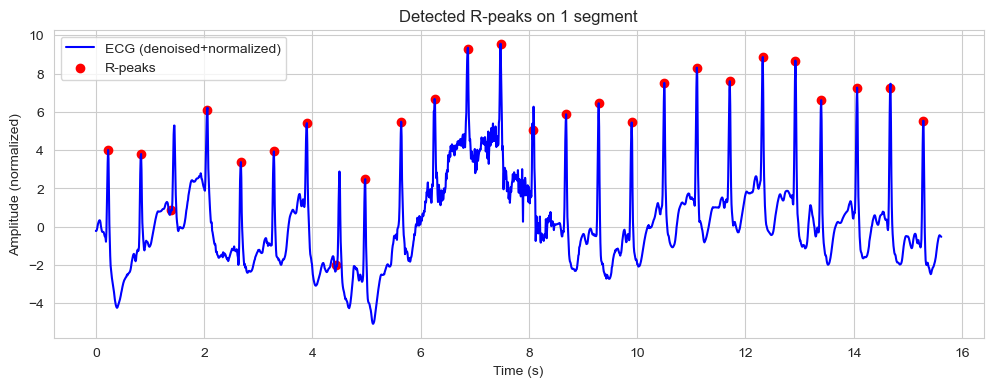

In [73]:
 valid_r_peaks = r_peaks[r_peaks < 2000]  # Only use peaks within first 2000 samples

plt.figure(figsize=(12, 4))
time_axis = np.arange(len(seg_norm)) / fs_new
plt.plot(time_axis[:2000], seg_norm[:2000], label="ECG (denoised+normalized)", color='blue')
plt.scatter(time_axis[valid_r_peaks], seg_norm[valid_r_peaks], color='red', label="R-peaks")
plt.title("Detected R-peaks on 1 segment")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (normalized)")
plt.legend()
plt.show()


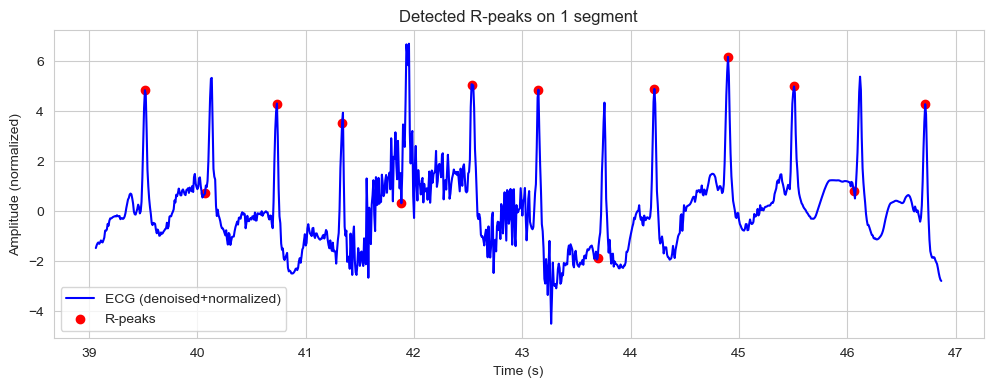

In [76]:
valid_r_peaks = r_peaks[(r_peaks > 5000) & (r_peaks < 6000)]

# Define time axis
time_axis = np.arange(len(seg_norm)) / fs_new

# Plot ECG signal in the given range
plt.figure(figsize=(12, 4))
plt.plot(time_axis[5000:6000], seg_norm[5000:6000], label="ECG (denoised+normalized)", color='blue')

# Plot R-peaks (ensure indices align correctly)
plt.scatter(time_axis[valid_r_peaks], seg_norm[valid_r_peaks], color='red', label="R-peaks")

plt.title("Detected R-peaks on 1 segment")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (normalized)")
plt.legend()
plt.show()

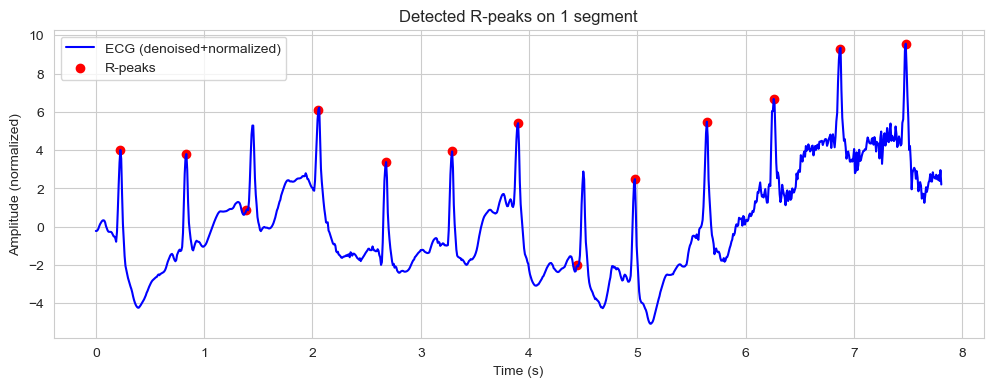

In [77]:
valid_r_peaks = r_peaks[r_peaks < 1000]  # Only use peaks within first 2000 samples

plt.figure(figsize=(12, 4))
time_axis = np.arange(len(seg_norm)) / fs_new
plt.plot(time_axis[:1000], seg_norm[:1000], label="ECG (denoised+normalized)", color='blue')
plt.scatter(time_axis[valid_r_peaks], seg_norm[valid_r_peaks], color='red', label="R-peaks")
plt.title("Detected R-peaks on 1 segment")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (normalized)")
plt.legend()
plt.show()


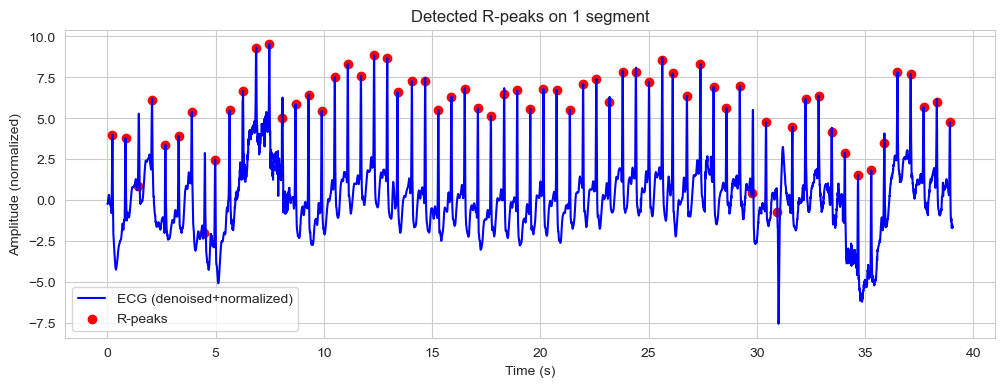

In [78]:
 valid_r_peaks = r_peaks[r_peaks < 5000]  # Only use peaks within first 2000 samples

plt.figure(figsize=(12, 4))
time_axis = np.arange(len(seg_norm)) / fs_new
plt.plot(time_axis[:5000], seg_norm[:5000], label="ECG (denoised+normalized)", color='blue')
plt.scatter(time_axis[valid_r_peaks], seg_norm[valid_r_peaks], color='red', label="R-peaks")
plt.title("Detected R-peaks on 1 segment")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (normalized)")
plt.legend()
plt.show()

In [79]:
rr_intervals = compute_rr_intervals(r_peaks, fs_new)
print("RR intervals (seconds):", rr_intervals[:10], "...")

RR intervals (seconds): [0.609 0.555 0.664 0.625 0.609 0.609 0.547 0.531 0.664 0.617] ...
